## Automated anisotropic resistivity inversion for efficient formation evaluation and uncertainty quantification

### Misael M. Morales, Oriyomi Raheem, Ali Eghbali, Michael Pyrcz, Carlos Torres-Verdin, 2024
***

In [ ]:
from main import *
ari = ARI()
case1, case2 = ari.load_data()

### Case 1

In [ ]:
case1_qinv = ari.quadratic_inversion(case1)

In [ ]:
inv1 = ari.resistivity_inversion(case1, x0=[0.5,1.45], Rvsh=2.813, Rhsh=0.775, 
                                 Wd_matrix=True, tolerance=1e-10, maxiter=1e5, 
                                 lambda_reg=1e-8, method='CG', bounds=None)

ari.plot_inversion_results(inv1, figsize=(20,12))

In [ ]:
inv1 = ari.resistivity_inversion(case1, x0=[0.5, 1.45], Rvsh=2.813, Rhsh=0.775,
                                 Wd_matrix=True, tolerance=1e-10, maxiter=1e5,
                                 lambda_reg=1e-8, method='L-BFGS-B', bounds=[(0,1),(None,None)])

ari.plot_inversion_results(inv1, figsize=(20,12))

### Case 2

In [ ]:
case2_qinv = ari.quadratic_inversion(case2)

In [ ]:
inv2 = ari.resistivity_inversion(case2, x0=[0.5,1.45], Rvsh=4.043, Rhsh=0.674,
                                 Wd_matrix=True, tolerance=1e-10, maxiter=1e5, 
                                 lambda_reg=1e-8, method='CG', bounds=None)

ari.plot_inversion_results(inv2, figsize=(20,12))

In [ ]:
inv2 = ari.resistivity_inversion(case2, x0=[0.5,1.45], Rvsh=4.043, Rhsh=0.674, 
                                 Wd_matrix=True, tolerance=1e-8, maxiter=1e5, 
                                 lambda_reg=1e-8, method='L-BFGS-B', bounds=[(0,1),(None,None)])

ari.plot_inversion_results(inv2, figsize=(20,12))

***
# Physics-Informed Artificial Neural Network
***

In [ ]:
from main import *
ari = ARI()
case1, case2 = ari.load_data()

In [ ]:
def plot_pinn_results(df, figsize=(15,10), subtitle:str=None):
    fig, axs = plt.subplots(1, 4, figsize=figsize, sharey=True)
    ax1, ax2, ax3, ax4 = axs

    ax11 = ax1.twiny()
    ari.plot_curve(ax1, df, 'GR', 0, 150, 'g', units='API', pad=8)
    ari.plot_curve(ax11, df, 'Csh_pred', 0, 1, 'k', units='v/v')

    ax21, ax22 = ax2.twiny(), ax2.twiny()
    ari.plot_curve(ax2, df, 'AT10', 0.2, 50, 'r', semilog=True, units='$\Omega\cdot m$', pad=8)
    ari.plot_curve(ax21, df, 'AT90', 0.2, 50, 'b', semilog=True, units='$\Omega\cdot m$', pad=16)
    ari.plot_curve(ax22, df, 'Rss_pred', 0.2, 50, 'k', units='$\Omega\cdot m$', semilog=True)

    ax31, ax32 = ax3.twiny(), ax3.twiny()
    ari.plot_curve(ax31, df, 'Rv', 0.2, 100, 'r', semilog=True, units='$\Omega\cdot m$', pad=8)
    ari.plot_curve(ax32, df, 'Rv_sim', 0.2, 100, 'k', units='$\Omega\cdot m$', semilog=True)
    ari.plot_curve(ax3, df, 'Rv_err', 0, 100, 'darkred', alpha=0.5, units='%', pad=16)

    ax41, ax42 = ax4.twiny(), ax4.twiny()
    ari.plot_curve(ax41, df, 'Rh', 0.2, 100, 'b', semilog=True, units='$\Omega\cdot m$', pad=8)
    ari.plot_curve(ax42, df, 'Rh_sim', 0.2, 100, 'k', units='$\Omega\cdot m$', semilog=True)
    ari.plot_curve(ax4, df, 'Rh_err', 0, 100, 'darkblue', alpha=0.5, units='%', pad=16)

    [ax.grid(True, which='both') for ax in axs]
    ax1.invert_yaxis()
    if subtitle is None:
        title = 'PINN Inversion Results'
    else:
        title = 'PINN Inversion Results | {}'.format(subtitle)
    fig.suptitle(title, weight='bold')
    plt.tight_layout()
    plt.show()

In [ ]:
class LSTMari(nn.Module):
    def __init__(self):
        super(LSTMari, self).__init__()
        self.fc1 = nn.Linear(2, 64)
        self.rn1 = nn.LSTM(input_size=64,  hidden_size=128, num_layers=2, batch_first=True, dropout=0.1)
        self.rn2 = nn.LSTM(input_size=128, hidden_size=64,  num_layers=2, batch_first=True, dropout=0.1)
        self.fc3 = nn.Linear(64, 2)
        
    def forward(self, x):
        x = nn.ReLU()(self.fc1(x))
        x, _ = self.rn1(x)
        x = nn.ReLU()(x)
        x, _ = self.rn2(x)
        x = nn.ReLU()(self.fc3(x))
        return x

In [ ]:
class siameseFNO(nn.Module):
    def __init__(self, Csh_constraint:bool=False):
        super(siameseFNO, self).__init__()
        self.conv_layers = nn.ModuleList([
            nn.Conv1d(2,   64,  kernel_size=3, padding=1),
            nn.Conv1d(64,  256, kernel_size=3, padding=1),
            nn.Conv1d(256, 64,  kernel_size=3, padding=1),
        ])      
        self.output_layer = nn.Conv1d(64, 1, kernel_size=3, padding=1)
        self.Csh_constraint = Csh_constraint

    def complex_relu(self, x):
        return torch.complex(torch.relu(x.real), torch.relu(x.imag))
        
    def forward(self, x):
        x = x.to(torch.complex64).permute(1,0)
        x_freq = torch.fft.fft(torch.fft.fftshift(x), dim=-2)
        for layer in self.conv_layers:
            layer.weight = nn.Parameter(layer.weight.to(torch.complex64))
            layer.bias = nn.Parameter(layer.bias.to(torch.complex64))
            x_freq = self.complex_relu(layer(x_freq))
        x_out = torch.fft.ifft(torch.fft.ifftshift(x_freq), dim=-2)
        x_out = self.output_layer(torch.abs(x_out))
        x_out = x_out.permute(1,0)
        return x_out

In [ ]:
class PhysicsInformedLoss(torch.nn.Module):
    def __init__(self, lambda_reg=1e-8):
        super(PhysicsInformedLoss, self).__init__()
        self.lambda_reg = lambda_reg

    def forward(self, inputs, outputs):
        Rv_true = inputs[:, 0]
        Rh_true = inputs[:, 1]

        Rvsh = torch.quantile(Rv_true, q=0.9)
        Rhsh = torch.quantile(Rh_true, q=0.9)

        Csh = outputs[:, 0]
        Rss = outputs[:, 1]
    
        Rvsim = (Csh*Rvsh + (1-Csh)*Rss)
        Rhsim = 1 / (Csh/Rhsh + (1-Csh)/Rss)

        Rverr = torch.abs((Rv_true - Rvsim)/Rv_true)
        Rherr = torch.abs((Rh_true - Rhsim)/Rh_true)
        costf = torch.cat((Rverr, Rherr), dim=0)
        loss  = torch.norm(costf, p=2) + self.lambda_reg*torch.norm(inputs, p=2)
        return loss

In [ ]:
d = lasio.read('well1.las').df()[['AT10','AT30','AT60','AT90','GR','RV72H_1D_FLT','RH72H_1D_FLT']].dropna()
#d = lasio.read('well2.LAS').df()[['AT10','AT30','AT60','AT90','HCGR','RV72_1DF','RH72_1DF']].dropna()

column_names = ['AT10', 'AT30', 'AT60', 'AT90', 'GR', 'Rv', 'Rh']
data = d.rename(columns=dict(zip(d.columns, column_names)))

res_aniso  = data[['Rv','Rh']][data.index < 10200]

Rvsh_win = np.nan_to_num(np.array(pd.Series(data['Rv']).rolling(250).max().tolist()), nan=data['Rv'].mean())
Rhsh_win = np.nan_to_num(np.array(pd.Series(data['Rh']).rolling(250).max().tolist()), nan=data['Rh'].mean())
Csh_lin  = (data['GR'] - data['GR'].min())/(data['GR'].max() - data['GR'].min())

R_min = np.min([data['Rh'].min(), data['Rv'].min()])
R_max = np.max([data['Rh'].max(), data['Rv'].max()])

In [ ]:
inputs         = torch.tensor(res_aniso.values, dtype=torch.float32)
dataset        = TensorDataset(inputs)
train_percent  = 0.8
xtrain, xvalid = random_split(dataset, [int(train_percent*len(dataset)), len(dataset)-int(train_percent*len(dataset))])
trainloader    = DataLoader(xtrain, batch_size=100, shuffle=False)
validloader    = DataLoader(xvalid, batch_size=100, shuffle=True)

csh_model  = siameseFNO(Csh_constraint=True)
rss_model  = siameseFNO()
criterion  = PhysicsInformedLoss()
optimizer  = torch.optim.AdamW([{'params': csh_model.parameters()}, {'params': rss_model.parameters()}], 
                               lr=1e-3, weight_decay=1e-6)

epochs = 251
train_loss, valid_loss = [], []

for epoch in range(epochs):
    
    epoch_train_loss = []
    csh_model.train()
    rss_model.train()
    for batch in trainloader:
        optimizer.zero_grad()
        x = batch[0]
        ycsh = csh_model(x)
        yrss = rss_model(x)
        y = torch.cat((ycsh, yrss), dim=1)
        loss = criterion(x, y)
        loss.backward()
        optimizer.step()
        epoch_train_loss.append(loss.item())
    train_loss.append(np.mean(epoch_train_loss))

    csh_model.eval()
    rss_model.eval()
    epoch_valid_loss = []
    with torch.no_grad():
        x = next(iter(validloader))[0]
        ycsh = csh_model(x)
        yrss = rss_model(x)
        y = torch.cat((ycsh, yrss), dim=1)
        loss = criterion(x, y)
        epoch_valid_loss.append(loss.item())
    valid_loss.append(np.mean(epoch_valid_loss))

    if epoch % 50 == 0:
        print('Epoch: {} | Loss: {:.4f} | Valid Loss: {:.4f}'.format(epoch, train_loss[-1], valid_loss[-1]))

In [ ]:
plt.figure(figsize=(6,3))
plt.plot(range(epochs), train_loss, label='Trianing', c='tab:blue')
plt.plot(range(epochs), valid_loss, label='Validation', c='tab:orange')
plt.legend(facecolor='lightgrey', edgecolor='k')
plt.grid(True, which='both')
plt.xlabel('Epoch'); plt.ylabel('Loss')
plt.xlim(-2, epochs+2)
plt.tight_layout()
plt.show()

In [ ]:
csh_pred = csh_model(inputs).detach().numpy().squeeze()
rss_pred = rss_model(inputs).detach().numpy().squeeze()
print('Csh: min={:.3f} | max={:.3f}'.format(csh_pred.min(), csh_pred.max()))

Rvsh_win, Rhsh_win = np.quantile(res_aniso['Rv'], q=0.9), np.quantile(res_aniso['Rh'], q=0.9)

Rv_sim = (csh_pred*Rvsh_win + (1-csh_pred)*rss_pred)
Rh_sim = 1 / (csh_pred/Rhsh_win + (1-csh_pred)/rss_pred)

Rv_err = np.abs((Rv_sim - res_aniso['Rv'].values)/res_aniso['Rv'].values) * 100
Rh_err = np.abs((Rh_sim - res_aniso['Rh'].values)/res_aniso['Rh'].values) * 100

sol = pd.DataFrame({'Csh_pred':csh_pred, 'Rss_pred':rss_pred,
                    'Rv_sim':Rv_sim, 'Rh_sim':Rh_sim,
                    'Rv_err':Rv_err, 'Rh_err':Rh_err}, index=res_aniso.index)

results = pd.concat([data, sol], axis=1)
plot_pinn_results(results, subtitle='Chevron 2009')

***
# END
***

In [2]:
from main import *
ari = ARI()
case1, case2 = ari.load_data()


------------------------------------------------------------
----------------------- VERSION INFO -----------------------
Torch version: 2.2.2+cu121 | Torch Built with CUDA? True
# Device(s) available: 1, Name(s): NVIDIA GeForce RTX 3080
------------------------------------------------------------



In [4]:
ali_cg = loadmat('Ali/sol.mat', simplify_cells=True)['sol']
ali_Csh = ali_cg[0,:]
ali_Rss = ali_cg[1,:]

ali_Rvsh = 2.78
ali_Rhsh = 0.60

Rv_sim_ali = ali_Csh*ali_Rvsh + (1-ali_Csh)*ali_Rss
Rh_sim_ali = 1/(ali_Csh/ali_Rhsh + (1-ali_Csh)/ali_Rss)

ali = pd.read_csv('Ali/RVRH.csv', header=None)
d = ali.iloc[1:2156, 0].values
c = ali.iloc[1:2156, 14].values
r = ali.iloc[1:2156, 15].values
ali_sol = pd.DataFrame({'Csh_ALI':c, 'Rss_ALI':r}, index=d)
ali_sol['Rv_sim_ALI'] = c*ali_Rvsh + (1-c)*r
ali_sol['Rh_sim_ALI'] = 1/(c/ali_Rhsh + (1-c)/r)

In [103]:
def quadratic_inversion(df, Rvsh=None, Rhsh=None):
    quad_inv = []
    if Rvsh is None:
        Rvsh = df['Rv'].iloc[np.argmax(df['GR'])]
    if Rhsh is None:
        Rhsh = df['Rh'].iloc[np.argmax(df['GR'])]
    for _, row in df.iterrows():
        Rv, Rh = row['Rv'], row['Rh']
        a = Rh*Rvsh - Rh*Rhsh
        b = Rv**2 + Rvsh*Rhsh - 2*Rh*Rhsh
        c = Rv*Rhsh - Rh*Rhsh
        qsol = np.roots([a,b,c])
        if len(qsol) == 1:
            quad_inv.append({'Rss_q':qsol[0], 'Csh_q':np.nan})
        elif len(qsol) == 2:
            quad_inv.append({'Rss_q':qsol[0], 'Csh_q':qsol[1]})
        else:
            quad_inv.append({'Rss_q':np.nan, 'Csh_q':np.nan})
    quad_inv = pd.DataFrame(quad_inv, index=df.index)
    return quad_inv

In [218]:
d = lasio.read('well1.las').df()[['AT10','AT30','AT60','AT90','GR','RV72H_1D_FLT','RH72H_1D_FLT']].dropna()
column_names = ['AT10', 'AT30', 'AT60', 'AT90', 'GR', 'Rv', 'Rh']
data = d.rename(columns=dict(zip(d.columns, column_names)))
max_depth = 10188.75

R_min = np.min([data['Rh'].min(), data['Rv'].min()])
R_max = np.max([data['Rh'].max(), data['Rv'].max()])
print('R_min={:.2f} | R_max={:.2f}'.format(R_min, R_max))

mask1 = np.logical_and(d.index >= 9650, d.index <= 9822)
mask2 = np.logical_and(d.index >= 9822, d.index <= 10085)
mask3 = np.logical_and(d.index >= 10085, d.index <= max_depth)
masks = [mask1, mask2, mask3]

Rvsh_win = np.zeros(len(data))
Rhsh_win = np.zeros(len(data))

for i, mask in enumerate(masks):
    Rvsh_win[mask] = np.quantile(data['Rv'][mask], 0.99)
    Rhsh_win[mask] = np.quantile(data['Rh'][mask], 0.99)

data['Rvsh_win'], data['Rhsh_win'] = Rvsh_win, Rhsh_win
data['Csh_lin']  = (data['GR'] - data['GR'].min())/(data['GR'].max() - data['GR'].min())

qinv = np.abs(quadratic_inversion(data))
data = data.join(qinv)[data.index<=max_depth]
data

R_min=0.29 | R_max=67.58


,AT10,AT30,AT60,AT90,GR,Rv,Rh,Rvsh_win,Rhsh_win,Csh_lin,Rss_q,Csh_q
DEPTH:1,,,,,,,,,,,,
9650.00,1.0775,0.8261,0.7674,0.7382,103.6210,0.7839,0.7831,67.5848,6.9592,0.962199,1.125937,0.101321
9650.25,1.0791,0.8266,0.7685,0.7406,105.2029,0.7853,0.7827,67.5848,6.9592,0.981099,1.494839,0.248156
9650.50,1.0807,0.8271,0.7695,0.7429,106.7848,0.7887,0.7817,67.5848,6.9592,1.000000,2.628511,0.380443
9650.75,1.0823,0.8270,0.7668,0.7438,105.9264,0.7967,0.7794,67.5848,6.9592,0.989744,5.555457,0.446178
9651.00,1.0840,0.8268,0.7641,0.7448,105.0679,0.8133,0.7746,67.5848,6.9592,0.979486,11.882277,0.469544
...,...,...,...,...,...,...,...,...,...,...,...,...
10187.75,0.9127,0.7351,0.6905,0.6740,92.2602,2.8578,0.5927,5.2337,0.8681,0.826458,1893.510411,0.225386
10188.00,0.9150,0.7362,0.6907,0.6740,91.5994,2.8661,0.5923,5.2337,0.8681,0.818563,1906.399226,0.224874
10188.25,0.9179,0.7375,0.6919,0.6761,91.7246,2.8510,0.5922,5.2337,0.8681,0.820059,1885.932856,0.225853


In [238]:
res_aniso = data[['Rv', 'Rh', 'Csh_lin', 'Csh_q', 'Rvsh_win', 'Rhsh_win']]

lambda_reg = 1e-10
sol, fun, jac, nfev = [], [], [], []

def objective(variables, *args):
    Csh, Rs = variables   
    Rv,  Rh = args[0], args[1]
    Rvsh, Rhsh = args[2], args[3]
    eq1 = (Csh*Rvsh + (1-Csh)*Rs) - Rv
    eq2 = (Csh/Rhsh + (1-Csh)/Rs) - (1/Rh)   
    eqs = [eq1/Rv, eq2*Rh]
    return linalg.norm(eqs,2) + lambda_reg*linalg.norm(variables,2)

def constraint(variables):
    Csh, Rss = variables
    Csh = np.clip(Csh, 0, 1)
    return Csh, Rss

for _, row in res_aniso.iterrows():
    Rv_value, Rh_value = row['Rv'],       row['Rh']
    Rvsh_win, Rhsh_win = row['Rvsh_win'], row['Rhsh_win']
    Csh_lin,  Csh_quad = row['Csh_lin'],  row['Csh_q']
    solution = optimize.minimize(objective,
                                 x0          = [Csh_lin, np.mean([Rv_value, Rh_value])],
                                 args        = (Rv_value, Rh_value, Rvsh_win, Rhsh_win),
                                 method      = 'L-BFGS-B',
                                 bounds      = [(0.0001,0.9999),(2e-2, 2e3)], #(R_min, R_max)
                                 tol         = 1e-6,
                                 options     = {'maxiter':1e3})
    fun.append(solution.fun)
    jac.append(solution.jac); nfev.append(solution.nfev)
    jac_arr = np.array(jac)
    jac1, jac2 = jac_arr[:,0], jac_arr[:,1]
    sol.append({'Rv':Rv_value, 'Rh':Rh_value, 'Csh_pred':solution.x[0], 'Rss_pred':solution.x[1]})

sol = pd.DataFrame(sol, index=res_aniso.index)
sol['fun'], sol['nfev'], sol['jac1'], sol['jac2'] = fun, nfev, jac1, jac2
sol['jac_norm'] = linalg.norm(jac, axis=1)

sol['Rv_sim'] = sol['Csh_pred']*data['Rvsh_win'] + (1-sol['Csh_pred'])*sol['Rss_pred']
sol['Rh_sim'] = 1/(sol['Csh_pred']/data['Rhsh_win'] + (1-sol['Csh_pred'])/sol['Rss_pred'])
sol.head()

,Rv,Rh,Csh_pred,Rss_pred,fun,nfev,jac1,jac2,jac_norm,Rv_sim,Rh_sim
DEPTH:1,,,,,,,,,,,
9650.00,0.7839,0.7831,0.000100,0.780144,5.254258e-03,69,59.894141,-0.000003,59.894141,0.786825,0.780214
9650.25,0.7853,0.7827,0.000100,0.780640,3.622289e-03,60,59.790009,0.000051,59.790009,0.787320,0.780709
9650.50,0.7887,0.7817,0.000106,0.781627,7.086917e-07,123,58.547691,1.660579,58.571236,0.788700,0.781701
9650.75,0.7967,0.7794,0.000262,0.779220,1.002595e-06,123,64.779685,1.778458,64.804093,0.796700,0.779401
9651.00,0.8133,0.7746,0.000585,0.774198,6.205585e-07,135,15.420658,0.603077,15.432446,0.813300,0.774600


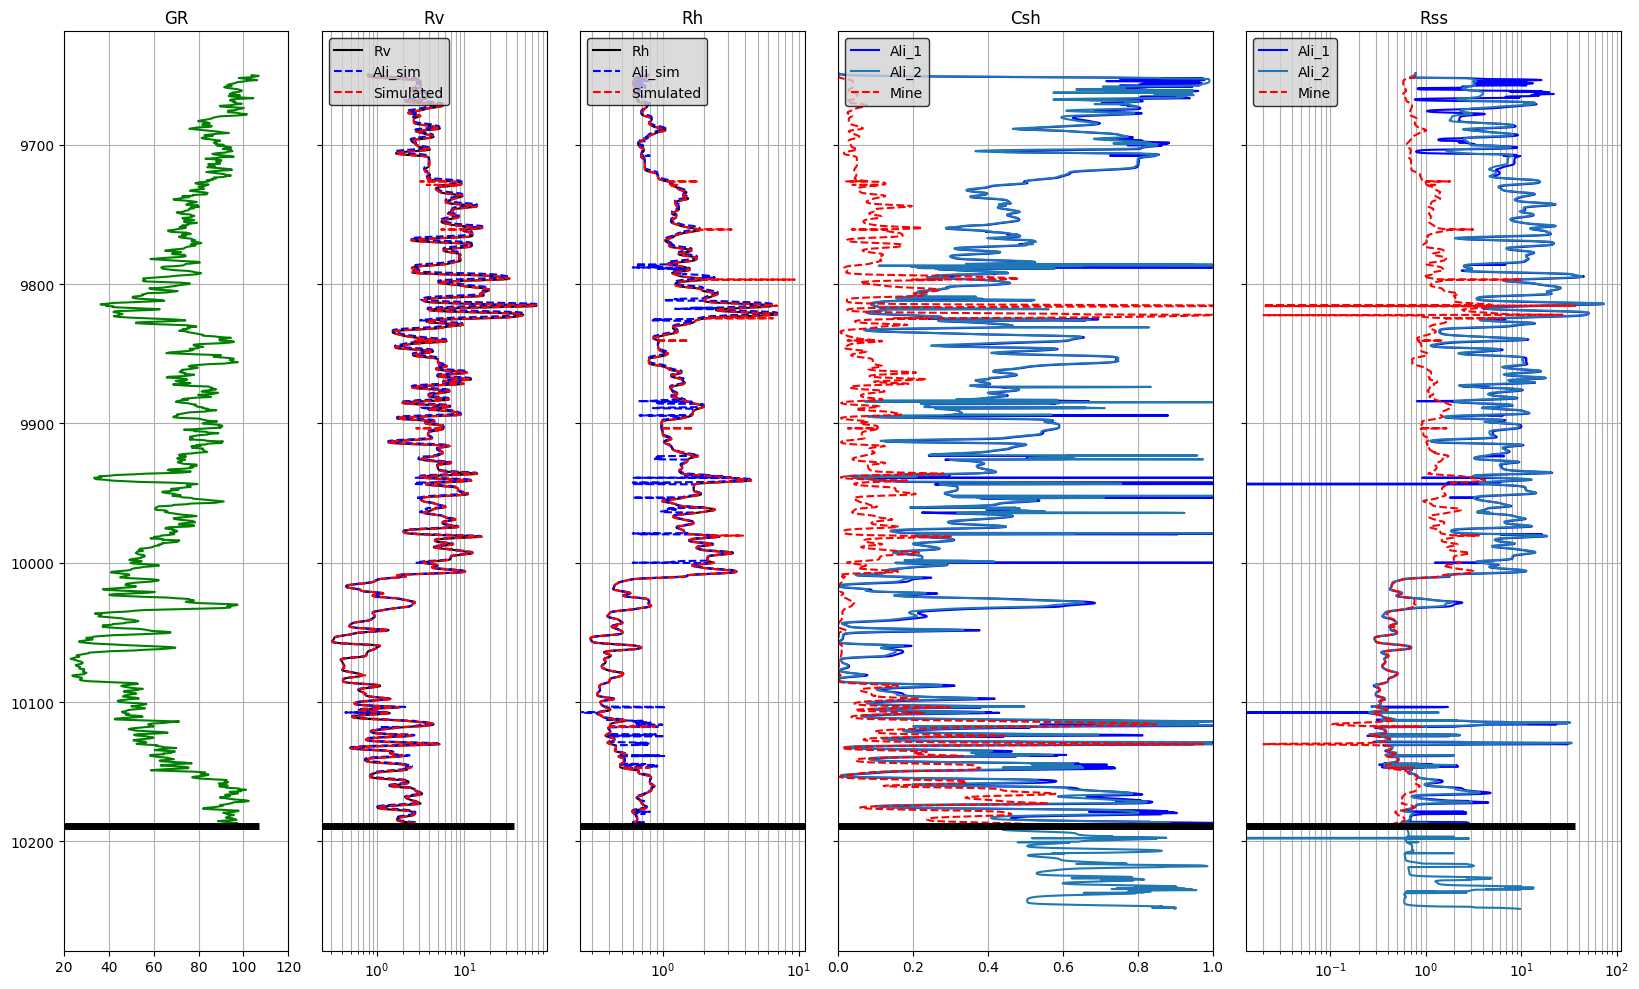

In [239]:
fig, axs = plt.subplots(1,5, figsize=(16.5,10), sharey=True, width_ratios=[0.6,0.6,0.6,1,1])
ax1, ax2, ax3, ax4, ax5 = axs
colors = ['darkviolet','royalblue','firebrick']

ax1.plot(data['GR'], data.index, c='g', label='GR')
ax1.grid(True, which='both')
ax1.set(xlim=(20,120), title='GR')
ax1.hlines(10188.75, 0, case1['GR'].max(), color='k', lw=5)

ax2.plot(data['Rv'], data.index, c='k', label='Rv')
ax2.plot(Rv_sim_ali, ali.iloc[1:2156,0], c='b', ls='--', label='Ali_sim')
ax2.plot(sol['Rv_sim'], sol.index, c='r', ls='--', label='Simulated')
ax2.set(xscale='log', title='Rv')
ax2.grid(True, which='both')
ax2.legend(loc='upper left', facecolor='lightgrey', edgecolor='k')
ax2.hlines(10188.75, 0, sol['Rss_pred'].max(), color='k', lw=5)

ax3.plot(data['Rh'], data.index, c='k', label='Rh')
ax3.plot(Rh_sim_ali, ali.iloc[1:2156,0], c='b', ls='--', label='Ali_sim')
ax3.plot(sol['Rh_sim'], sol.index, c='r', ls='--', label='Simulated')
ax3.set(xscale='log', title='Rh')
ax3.grid(True, which='both')
ax3.legend(loc='upper left', facecolor='lightgrey', edgecolor='k')
ax3.hlines(10188.75, 0, sol['Rss_pred'].max(), color='k', lw=5)

ax4.plot(ali_Csh, ali.iloc[1:2156,0], label='Ali_1', c='b')
ax4.plot(ali.iloc[:,14], ali.iloc[:,0], label='Ali_2')
ax4.plot(sol['Csh_pred'], sol.index, label='Mine', ls='--', c='r')
ax4.set(title='Csh', xlim=(0,1))
ax4.legend(loc='upper left', facecolor='lightgrey', edgecolor='k')
ax4.grid(True, which='both')
ax4.hlines(10188.75, 0, 1, color='k', lw=5)

ax5.plot(ali_Rss, ali.iloc[1:2156,0], label='Ali_1', c='b')
ax5.plot(ali.iloc[:,15], ali.iloc[:,0], label='Ali_2')
ax5.plot(sol['Rss_pred'], sol.index, label='Mine', ls='--', c='r')
ax5.set(xscale='log', title='Rss'); 
ax5.legend(loc='upper left', facecolor='lightgrey', edgecolor='k')
ax5.grid(True, which='both')
ax5.hlines(10188.75, 0, sol['Rss_pred'].max(), color='k', lw=5)

ax1.invert_yaxis()
plt.tight_layout()
plt.show()

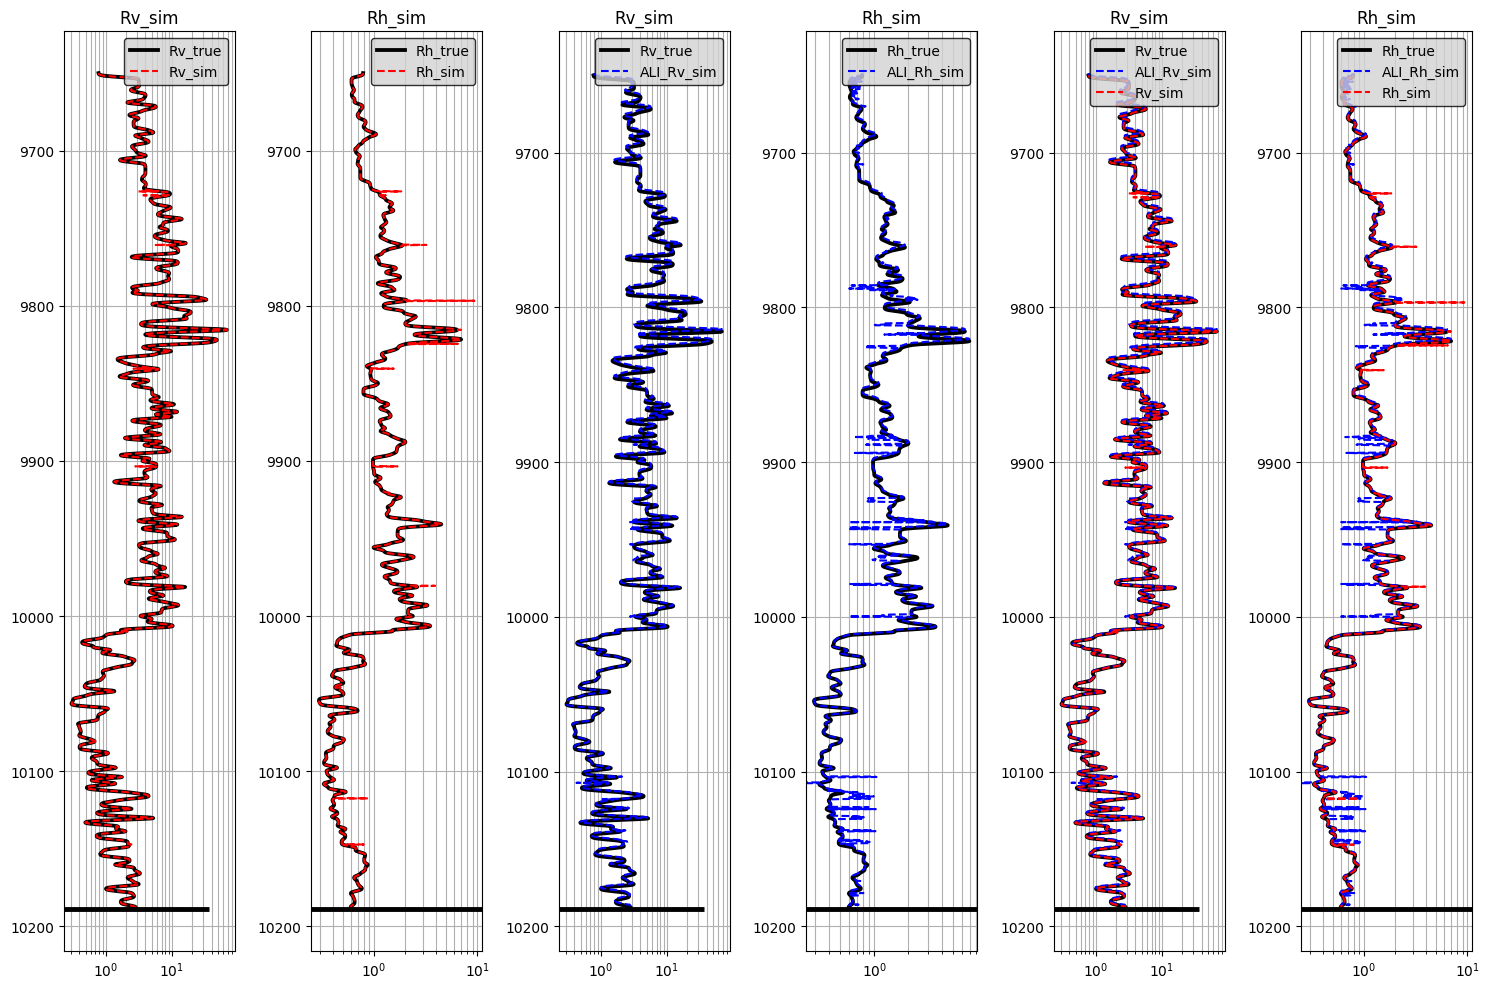

In [240]:
fig, axs = plt.subplots(1, 6, figsize=(15,10))
ax1, ax2, ax3, ax4, ax5, ax6 = axs

ax1.plot(sol['Rv'], sol.index, c='k', lw=2.75, label='Rv_true')
ax1.plot(sol['Rv_sim'], sol.index, c='r', ls='--', label='Rv_sim')
ax1.set(title='Rv_sim'); ax1.grid(True, which='both'); ax1.set_xscale('log')
ax1.legend(facecolor='lightgrey', edgecolor='k', loc='upper right')

ax2.plot(sol['Rh'], sol.index, c='k', lw=2.75, label='Rh_true')
ax2.plot(sol['Rh_sim'], sol.index, c='r', ls='--', label='Rh_sim')
ax2.set(title='Rh_sim'); ax2.grid(True, which='both'); ax2.set_xscale('log')
ax2.legend(facecolor='lightgrey', edgecolor='k', loc='upper right')

ax3.plot(sol['Rv'], sol.index, c='k', lw=2.75, label='Rv_true')
ax3.plot(Rv_sim_ali, ali.iloc[:2155,0], c='b', ls='--', label='ALI_Rv_sim')
ax3.set(title='Rv_sim'); ax3.grid(True, which='both'); ax3.set_xscale('log')
ax3.legend(facecolor='lightgrey', edgecolor='k', loc='upper right')

ax4.plot(sol['Rh'], sol.index, c='k', lw=2.75, label='Rh_true')
ax4.plot(Rh_sim_ali, ali.iloc[:2155,0], c='b', ls='--', label='ALI_Rh_sim')
ax4.set(title='Rh_sim'); ax4.grid(True, which='both'); ax4.set_xscale('log')
ax4.legend(facecolor='lightgrey', edgecolor='k', loc='upper right')

ax5.plot(sol['Rv'], sol.index, c='k', lw=2.75, label='Rv_true')
ax5.plot(Rv_sim_ali, ali.iloc[:2155,0], c='b', ls='--', label='ALI_Rv_sim')
ax5.plot(sol['Rv_sim'], sol.index, c='r', ls='--', label='Rv_sim')
ax5.set(title='Rv_sim'); ax5.grid(True, which='both'); ax5.set_xscale('log')
ax5.legend(facecolor='lightgrey', edgecolor='k', loc='upper right')

ax6.plot(sol['Rh'], sol.index, c='k', lw=2.75, label='Rh_true')
ax6.plot(Rh_sim_ali, ali.iloc[:2155,0], c='b', ls='--', label='ALI_Rh_sim')
ax6.plot(sol['Rh_sim'], sol.index, c='r', ls='--', label='Rh_sim')
ax6.set(title='Rh_sim'); ax6.grid(True, which='both'); ax6.set_xscale('log')
ax6.legend(facecolor='lightgrey', edgecolor='k', loc='upper right')

for ax in axs:
    ax.hlines(10188.75, 0, sol['Rss_pred'].max(), color='k', lw=3.5)
    ax.invert_yaxis()
    
plt.tight_layout()
plt.show()

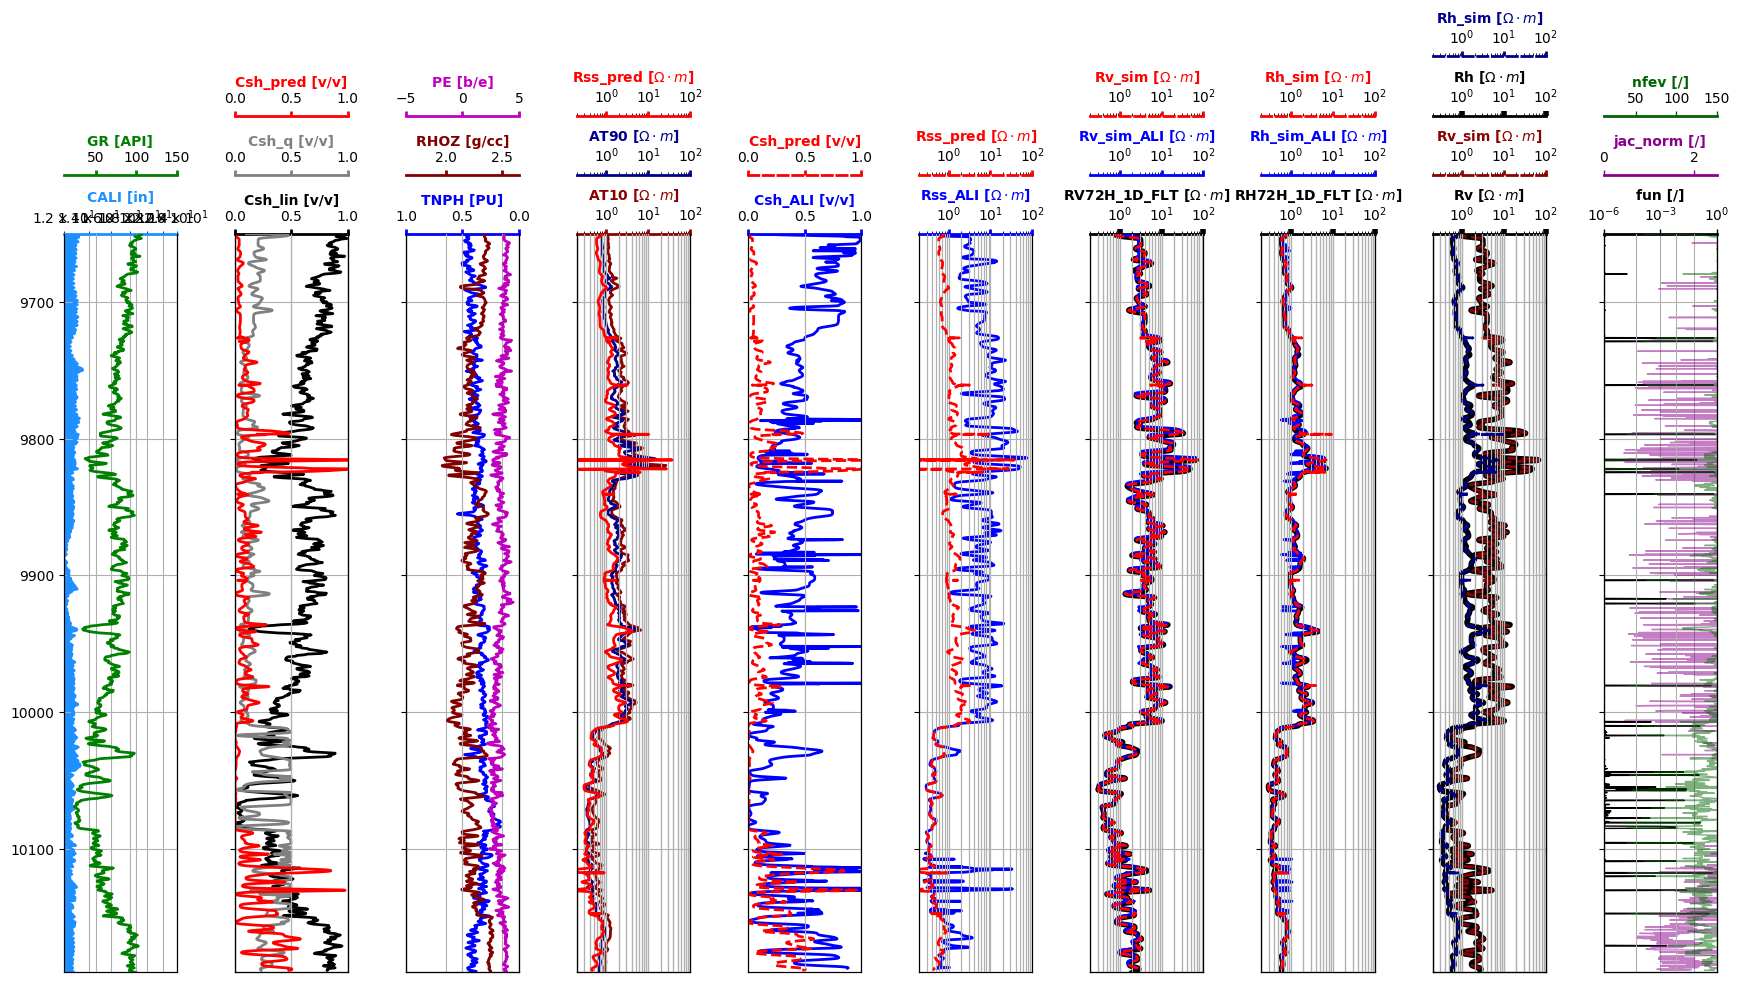

In [247]:
df = lasio.read('well1.las').df()

fig, axs = plt.subplots(1, 10, figsize=(17.5,10), sharey=True)
ax0, ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9 = axs

ax01 = ax0.twiny()
ari.plot_curve(ax0, df, 'CALI', 12, 24, 'dodgerblue', units='in', fill=True, semilog=True, pad=0)
ari.plot_curve(ax01, df, 'GR', 10, 150, 'g', units='API', pad=8)

ax11, ax12 = ax1.twiny(), ax1.twiny()
ari.plot_curve(ax1, data, 'Csh_lin', 0, 1, 'k', units='v/v', pad=0)
ari.plot_curve(ax11, data, 'Csh_q', 0, 1, 'gray', units='v/v', pad=8)
ari.plot_curve(ax12, sol, 'Csh_pred', 0, 1, 'r', units='v/v', pad=16)

ax21, ax22 = ax2.twiny(), ax2.twiny()
ari.plot_curve(ax2, df, 'TNPH', 1, 0, 'b', units='PU', pad=0)
ari.plot_curve(ax21, df, 'RHOZ', 1.65, 2.65, 'maroon', units='g/cc', pad=8)
ari.plot_curve(ax22, df, 'PE', -5, 5, 'm', units='b/e', pad=16)

ax31, ax32 = ax3.twiny(), ax3.twiny()
ari.plot_curve(ax3, df, 'AT10', 0.2, 100, 'darkred', semilog=True, units='$\Omega\cdot m$', pad=0)
ari.plot_curve(ax31, df, 'AT90', 0.2, 100, 'darkblue', semilog=True, units='$\Omega\cdot m$', pad=8)
ari.plot_curve(ax32, sol, 'Rss_pred', 0.2, 100, 'r', semilog=True, units='$\Omega\cdot m$', pad=16)

ax41 = ax4.twiny()
ari.plot_curve(ax4, ali_sol, 'Csh_ALI', 0, 1, 'b', units='v/v', pad=0)
ari.plot_curve(ax41, sol, 'Csh_pred', 0, 1, 'r', ls='--', units='v/v', pad=8)

ax51 = ax5.twiny()
ari.plot_curve(ax5, ali_sol, 'Rss_ALI', 0.2, 100, 'b', semilog=True, units='$\Omega\cdot m$', pad=0)
ari.plot_curve(ax51, sol, 'Rss_pred', 0.2, 100, 'r', ls='--', semilog=True, units='$\Omega\cdot m$', pad=8)

ax61, ax62 = ax6.twiny(), ax6.twiny()
ari.plot_curve(ax6, df, 'RV72H_1D_FLT', 0.2, 100, 'k', s=4, semilog=True, units='$\Omega\cdot m$', pad=0)
ari.plot_curve(ax61, ali_sol, 'Rv_sim_ALI', 0.2, 100, 'b', semilog=True, units='$\Omega\cdot m$', pad=8)
ari.plot_curve(ax62, sol, 'Rv_sim', 0.2, 100, 'r', ls='--', semilog=True, units='$\Omega\cdot m$', pad=16)

ax71, ax72 = ax7.twiny(), ax7.twiny()
ari.plot_curve(ax7, df, 'RH72H_1D_FLT', 0.2, 100, 'k', s=4, semilog=True, units='$\Omega\cdot m$', pad=0)
ari.plot_curve(ax71, ali_sol, 'Rh_sim_ALI', 0.2, 100, 'b', semilog=True, units='$\Omega\cdot m$', pad=8)
ari.plot_curve(ax72, sol, 'Rh_sim', 0.2, 100, 'r', ls='--', semilog=True, units='$\Omega\cdot m$', pad=16)

ax81, ax82, ax83 = ax8.twiny(), ax8.twiny(), ax8.twiny()
ari.plot_curve(ax8, data, 'Rv', 0.2, 100, 'k', s=4, semilog=True, units='$\Omega\cdot m$', pad=0)
ari.plot_curve(ax81, sol, 'Rv_sim', 0.2, 100, 'darkred', ls='--', semilog=True, units='$\Omega\cdot m$', pad=8)
ari.plot_curve(ax82, data, 'Rh', 0.2, 100, 'k', s=4, semilog=True, units='$\Omega\cdot m$', pad=16)
ari.plot_curve(ax83, sol, 'Rh_sim', 0.2, 100, 'darkblue', ls='--', semilog=True, units='$\Omega\cdot m$', pad=24)

ax91, ax92 = ax9.twiny(), ax9.twiny()
ari.plot_curve(ax9, sol, 'fun', 1e-6, 1e0, 'k', s=1, semilog=True, units='/', pad=0)
ari.plot_curve(ax91, sol, 'jac_norm', 0, 2.5, 'darkmagenta', s=1, units='/', pad=8, alpha=0.5)
ari.plot_curve(ax92, sol, 'nfev', 10, 150, 'darkgreen', s=1, units='/', pad=16, alpha=0.5)

ax1.set_ylim(10190, 9650)

plt.tight_layout()
plt.show()